<a href="https://colab.research.google.com/github/Hafsaaa/forcast/blob/master/TimeSeriesProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scipy import stats
from math import sqrt
%matplotlib inline

I have uploaded the provided dataset to my personnal github, which is the simplest way to allow reading external data in Google Colab.

In [0]:
#data reading
data = pd.read_csv('https://raw.githubusercontent.com/Hafsaaa/forcast/master/darwin.data')
data.columns = ["value"]
data.head()

,value
0,6.3
1,7.5
2,8.5
3,9.4
4,12.3


# Statistical Modeling

1/ Visualising out time series:

We can clearly see graphically from the first plot that the data is stationnary, and presents a possible seasonality.

The second plot on a focused subset of data confirms a clear monthly frequency f=12

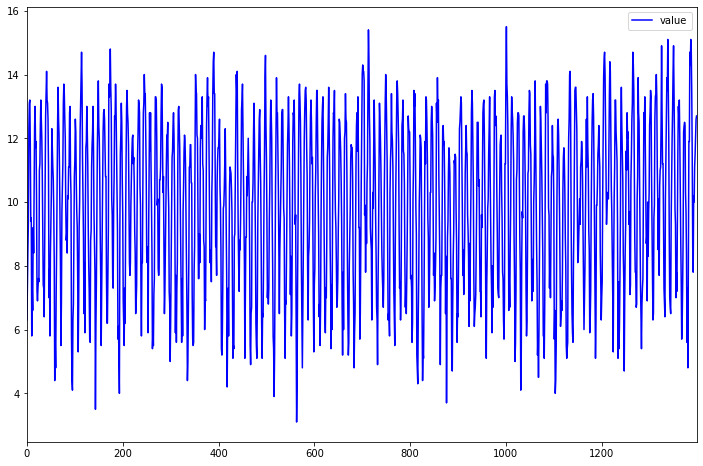

In [0]:
#plotting data 
data.plot(color='b', legend=True, figsize=(12,8))

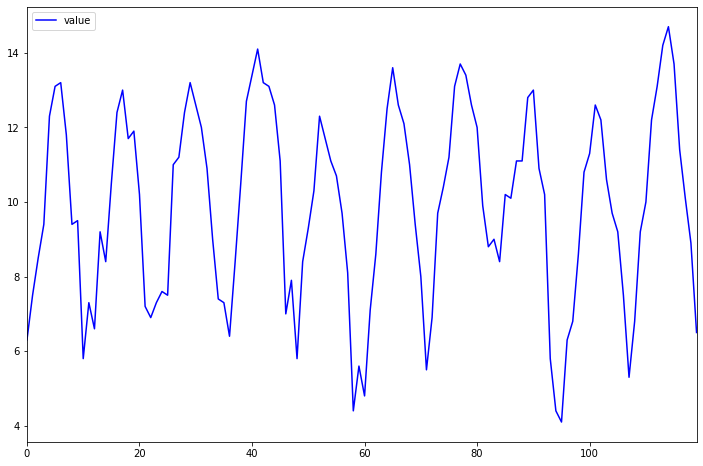

In [0]:
#plotting small subset of data to check the frequency
data[:120].plot(color='b', legend=True, figsize=(12,8))

2/ Extracting time series components:

Using seasonal decomposition with a frequency f=12 that we found earlier, we can extract the time series components (trend/seasonnal/residual) 

N/B: While the seasonal component is clear, the trend looks like a time series of its own(I remember seeing this case in class).

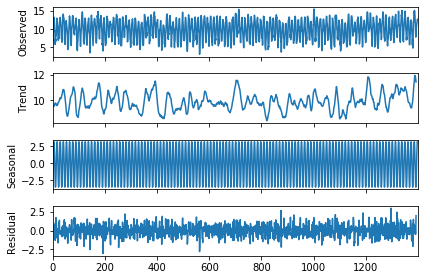

In [0]:
#extracting the time series components 
seasonal_decompose(data["value"],freq=12).plot();

3/ Data Partionning : 

A very simple popular approach we can use to partition our data is setting the last 10% of our data as a testing set; then a further 10% from the remaining data as validation data. This technique is sometimes called semi-random partitioning.

It is also very convenient for our dataset (1400 = 1120 + 140 x 2).

In [0]:
#data partitionning using the 80/10/10 division, which is optimal for a dataset of this size

val_ind=int(len(data)*0.80)
tst_ind=int(len(data)*0.90)

train_data=data[:val_ind]
validation_data=data[val_ind:tst_ind]
test_data=data[tst_ind:]

#test+validation 
merge_data=data[val_ind:]

4/ Data Scaling:

We will be using Standarization: shifting the distribution of each attribute to have a mean 0 and a standard deviation 1. 

It is mainly useful in multivariate models to harmonize all parameters, but also make machine learning processes faster. 

It will be useful in the second part with machine learning models

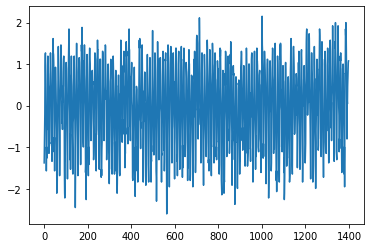

In [0]:
#data scaling 

normalized_data = preprocessing.scale(data)
plt.plot(normalized_data)


1/ As we have seen earlier in the first graph, the data is visually indeed stationary. 

We can further confirm that with Augmented-Dickey Fuller Test below, where we find that that the p-value is below 0.05, indicating stationarity. The critical values found further confirm the strong stationnarity.

2/ Data is stationary, no transformation needed.

In [0]:
#ADF statistical test to check stationnarity
result = adfuller(data["value"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.704611
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


3/ ACF and PACF plots below, first with a big amount of lags; then a much smaller one; all to have a better visibility.

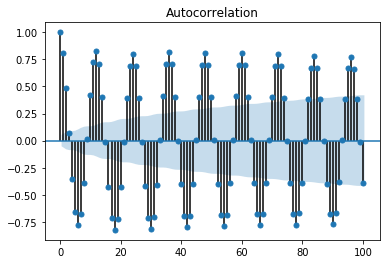

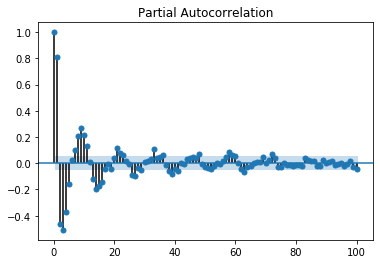

In [0]:
#ACF and PACF plotting
plot_acf(data, lags=100)
plot_pacf(data, lags=100)

plt.show()

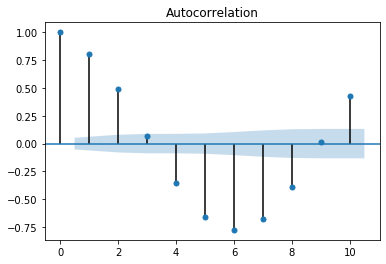

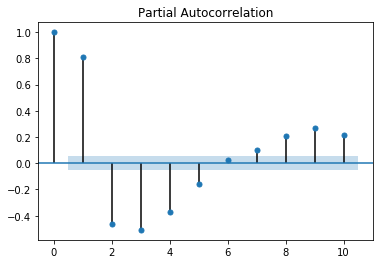

In [0]:
#ACF and PACF plotting with less lags

plot_acf(data, lags=10)
plot_pacf(data, lags=10)

plt.show()

4/ Model selection :

We notice that the ACF becomes insignificant for the first time after third lag; less significant after second lag. (p=2 or 3)

PACF becomes negative after second lag. (q=2)

Candidate models: d=0 (stationary) ARMA with p=2 or 3; q=2


5/ Below we will train these two models (ARMA 22 and ARMA 32) with the training dataset and check the training results.

In [0]:
# forecasting and training performance with model ARMA(2,2) 
# fit model
model2 = ARIMA(train_data, order=(2,0,2))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())



                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                 1119
Model:                     ARMA(2, 2)   Log Likelihood               -1572.782
Method:                       css-mle   S.D. of innovations              0.984
Date:                Sun, 26 Jan 2020   AIC                           3157.563
Time:                        23:45:39   BIC                           3187.685
Sample:                             0   HQIC                          3168.949
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8047      0.041    236.367      0.000       9.723       9.886
ar.L1.value     1.7257      0.004    444.607      0.000       1.718       1.733
ar.L2.value    -0.9917      0.004   -256.757    

In [0]:
#forecasting and training performance with selected models ARMA(3,2)
warnings.filterwarnings('ignore')   #may trigger a small calculation warning

# fit model
model = ARIMA(train_data, order=(3,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())



                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                 1119
Model:                     ARMA(3, 2)   Log Likelihood               -1483.559
Method:                       css-mle   S.D. of innovations              0.907
Date:                Sun, 26 Jan 2020   AIC                           2981.119
Time:                        23:45:48   BIC                           3016.260
Sample:                             0   HQIC                          2994.402
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.7918   2.32e-05   4.23e+05      0.000       9.792       9.792
ar.L1.value     2.2338   5.35e-06   4.18e+05      0.000       2.234       2.234
ar.L2.value    -1.8689   4.48e-06  -4.18e+05    

6/ Bases on the results above, we can see that the standard errors of ARMA 32 are much less significant than ARMA 22; making us choose ARMA 32 as the better model.

7/ Graphical evaluation of the selected model's residuals below.

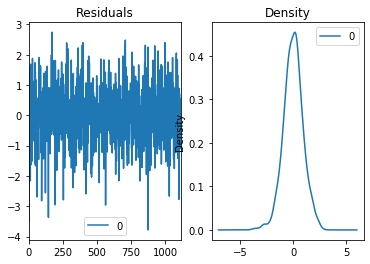

In [0]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()



8+9/ The residual errors do look grphically like white noise.

Staistically, with zero mean and uniform variance, they are indeed white noise.


10+11/ Generate forecasts of our selected model and plot them. 

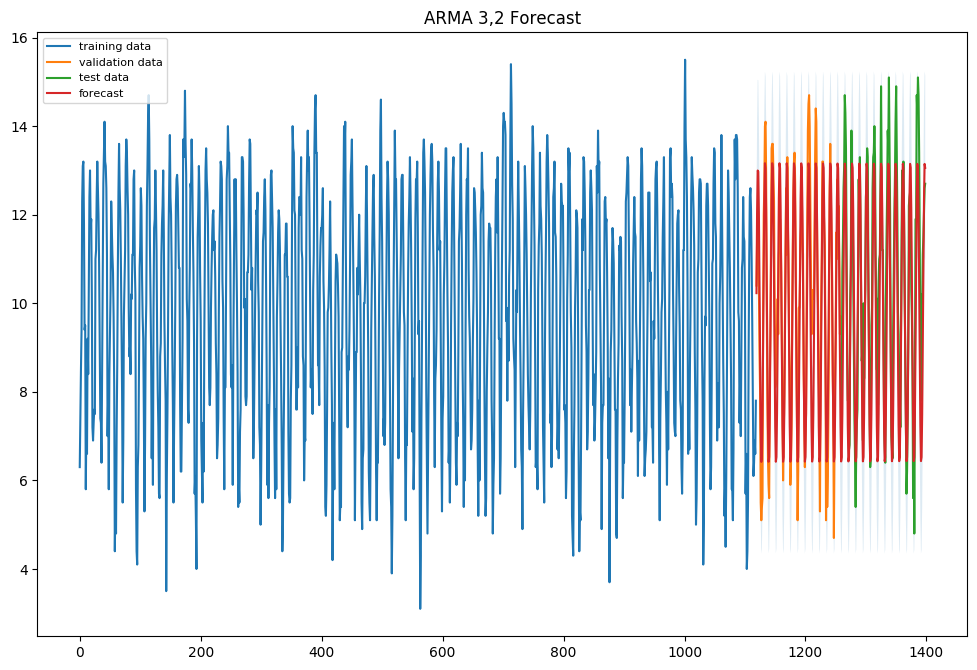

In [0]:
#plotting our selected model
# Build Model
model = ARIMA(train_data, order=(3, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(280, alpha=0.05)  # 95% confidence

# Make as pandas series for test + validation
fc_series = pd.Series(fc, index=merge_data.index)
lower_series = pd.Series(conf[:, 0], index=merge_data.index)
upper_series = pd.Series(conf[:, 1], index=merge_data.index)


# Plot
plt.figure(figsize=(12,8), dpi=100)

plt.plot(train_data, label='training data')
plt.plot(validation_data, label='validation data')
plt.plot(test_data, label='test data')

plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                  alpha=.15)


plt.title('ARMA 3,2 Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()


11/ Although it looks very simple and bland; we can notice that nost of the validation and test values are well inside the confidence interval; and the series's growth or drop are natched very accurately; making this forecast look rather good.

In [0]:
# Accuracy metrics for error calculation
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})



12/ Training and testing error calculation through accuracy metrics:

for both training and testing error below, we can notice that the performance metrics are rather good, for instance mape = 0.30 means that our nodel is 70% accurate, which is satisfactory for such a simple model.

In [0]:
#test error
forecast_accuracy(fc[:140], test_data.values)

{'mae': 2.9289288378555685,
 'mape': 0.2990948251085553,
 'me': -0.616616814090816,
 'mpe': 0.009948095320906302,
 'rmse': 3.5957790601810156}

In [0]:
#validation error
forecast_accuracy(fc[140:], validation_data.values)


{'mae': 2.8902422075427943,
 'mape': 0.319692701862107,
 'me': -0.2574421727968438,
 'mpe': 0.05285747227498653,
 'rmse': 3.528889570214048}

# Machine Learning Modeling

1+2/  Earlier in the statistical forecasts, we have seen that although the forecast is quite good, it was too simple to take into account more than a single level of information : the very first remark we had seen about the series's trend being itself a time series could not be exploited.

To add a layer of comprehension, we had to choose a type of RNN model named Long Short Term Memory (LSTM), which is renowned to be powerful for forecast of time series which present this trait.

Unfortunately, we may not be able to use its full power, as unlike statistical models, calculation times can take many hours whereas GoogleColab can disconnect in that timespan. I will try as much as possible to make simple choices.

3/ The most important hypothesis for RNN / LSTM usage is having non gaussian data. We'll make sure of that through a normality test, but also by calculating the skewness and kurtosis, to determine that the data indeed departs from the normal distribution.

Other hypothesis include data being stationnary, scaled, and being structured as having inputs and outputs; we will make the necessary transformations for that.

In [0]:
stat, p = stats.normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
print( 'Kurtosis of this distribution: {}'.format(stats.kurtosis(data)))
print( 'Skewness of this distribution: {}'.format(stats.skew(data)))


Statistics=264.723, p=0.000
Kurtosis of this distribution: [-0.9632169]
Skewness of this distribution: [-0.23145459]


3/ For a normal distribution, the kurtosis is 4.2 and skewness 1.8; in our case, it is extremely different; added to the normality test with p=0; our data is definitely not gaussian.

As for the other conditions, they will be satisfied with the  transformations below.


In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(df, lag=1):
	#df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [0]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# 5/ **Great LSTM explanation: **
source (https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

###

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at ht−1 and xt, and outputs a number between 0 and 1 for each number in the cell state Ct−1. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

Let’s go back to our example of a language model trying to predict the next word based on all the previous ones. In such a problem, the cell state might include the gender of the present subject, so that the correct pronouns can be used. When we see a new subject, we want to forget the gender of the old subject.

![Texte alternatif…](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, Ct that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

In the example of our language model, we’d want to add the gender of the new subject to the cell state, to replace the old one we’re forgetting.

![Texte alternatif…](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

It’s now time to update the old cell state, Ct−1, into the new cell state Ct. The previous steps already decided what to do, we just need to actually do it.

We multiply the old state by ft, forgetting the things we decided to forget earlier. Then we add it∗C~t

This is the new candidate values, scaled by how much we decided to update each state value.

In the case of the language model, this is where we’d actually drop the information about the old subject’s gender and add the new information, as we decided in the previous steps.

![Texte alternatif…](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

For the language model example, since it just saw a subject, it might want to output information relevant to a verb, in case that’s what is coming next. For example, it might output whether the subject is singular or plural, so that we know what form a verb should be conjugated into if that’s what follows next.

![Texte alternatif…](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)
# New section 
###


In [0]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

**4/** The Keras library with Tensorflow backend implementation of LSTM keeps essentially 3 modifiable parameters : batch_size, epoch,and neurons.

- The batch size controls how many predictions we must make at a time. For our case, one-step forecasts are simple and efficient; so batch_size can remain = 1.

- Epoch represents the number of training cycles; we want it to be as high as possible for better results as long as said results can be improved. There are also reccomendations stating to have an epoch number at least higher than the dataset's size. Unfortunately, the higher the number, the more time it takes; we had to compromise with n - 1500 fo be able to get results in less than an hour and n > len(data)

- Neurons is the number of layers we want our neural network to have. The more complexity we want, the more we could add. Seeing as we have a monovariate time series, 1 may just be more than enough for simplicity, but we can also try 2 and see the improvements.

**6/** Our two chosen LSTM models are thus (1,1500,1) and (1,1500,2)



**7/** The learning rate always becomes constant with the initial value that keras library provides due to the resetting of all the parameters. Therefore we are forced to choose a constant rate c = 0.001.

In [0]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [0]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(data, 1)
supervised_values = supervised.values

# split data into train and test-sets the same as part 1, except we'll use merge (test+val)
train, merge = supervised_values[0:-280], supervised_values[-280:]

# transform the scale of the data
scaler, train_scaled, merge_scaled = scale(train, merge)

**8-10/** Chosen models's study and comparison :

In [0]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

 

array([[-0.48997748],
       [-0.2605269 ],
       [-0.19344616],
       ...,
       [-0.36702156],
       [-0.301813  ],
       [-0.3412211 ]], dtype=float32)

In [0]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(merge_scaled)):
	# make one-step forecast
	X, y = merge_scaled[i, 0:-1], merge_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)

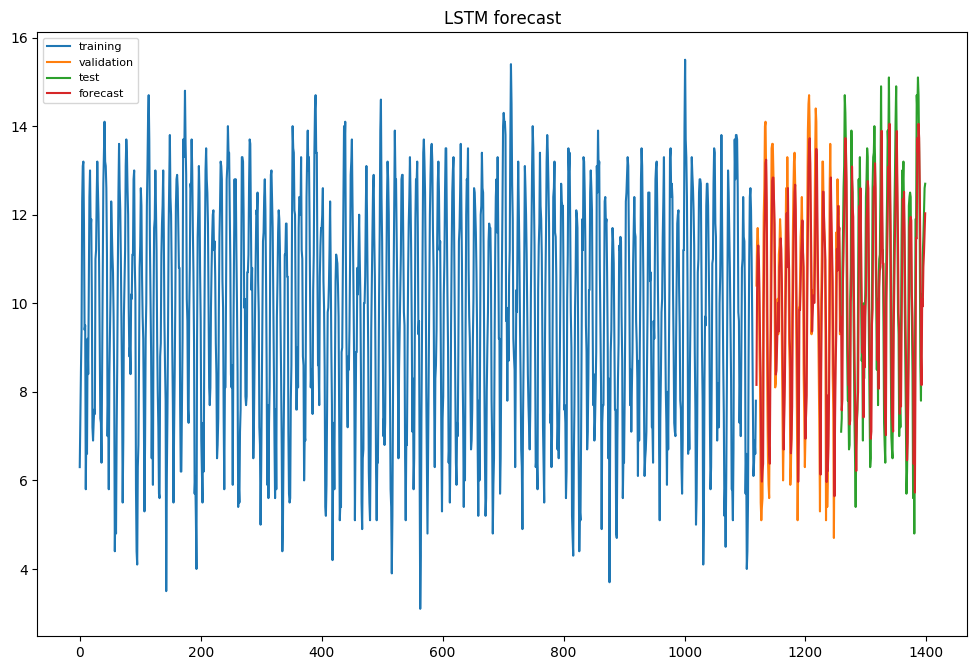

In [0]:
forcast_ser = pd.Series(predictions,index=merge_data.index)

plt.figure(figsize=(12,8),dpi=100)

plt.plot(train_data, label="training")
plt.plot(validation_data, label="validation")
plt.plot(test_data, label="test")

plt.plot(forcast_ser, label="forecast")
plt.title("LSTM forecast")

plt.legend(loc="upper left", fontsize=8)
plt.show()

In [0]:
#save model result
print(len(forcast_ser))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(forcast_ser)

280
1119     8.157391
1120    10.260705
1121    11.064181
1122    11.304677
1123    10.979852
1124    10.251743
1125     9.038822
1126     8.313534
1127     6.290449
1128     5.972810
1129     6.216865
1130     6.378122
1131     9.861277
1132    11.551543
1133    12.032269
1134    13.164959
1135    13.242379
1136    12.269947
1137     9.842570
1138     8.148952
1139     7.101127
1140     6.618361
1141     6.376847
1142     8.403002
1143     9.368754
1144    10.985998
1145    12.763205
1146    12.838577
1147    12.838338
1148    12.271230
1149    11.786938
1150     9.925119
1151     8.391736
1152     8.477620
1153     9.044456
1154     9.528749
1155    10.013304
1156     9.363642
1157    10.823983
1158    10.981378
1159    11.466971
1160    11.222383
1161    10.494020
1162     9.200085
1163     7.826929
1164     6.697072
1165     7.429799
1166     8.237627
1167     9.693341
1168    10.903952
1169    12.034326
1170    10.815504
1171    12.601715
1172    11.299795
1173    10.736821
1174  

In [0]:
# fit the model
lstm_model2 = fit_lstm(train_scaled, 1, 1500, 2)

# forecast the entire training dataset to build up state for forecasting
train_reshaped2 = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model2.predict(train_reshaped2, batch_size=1)


In [0]:
#train 2
# walk-forward validation on the test data
predictions2 = list()
for i in range(len(merge_scaled)):
	# make one-step forecast
	X, y = merge_scaled[i, 0:-1], merge_scaled[i, -1]
	yhat = forecast_lstm(lstm_model2, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions2.append(yhat)
	

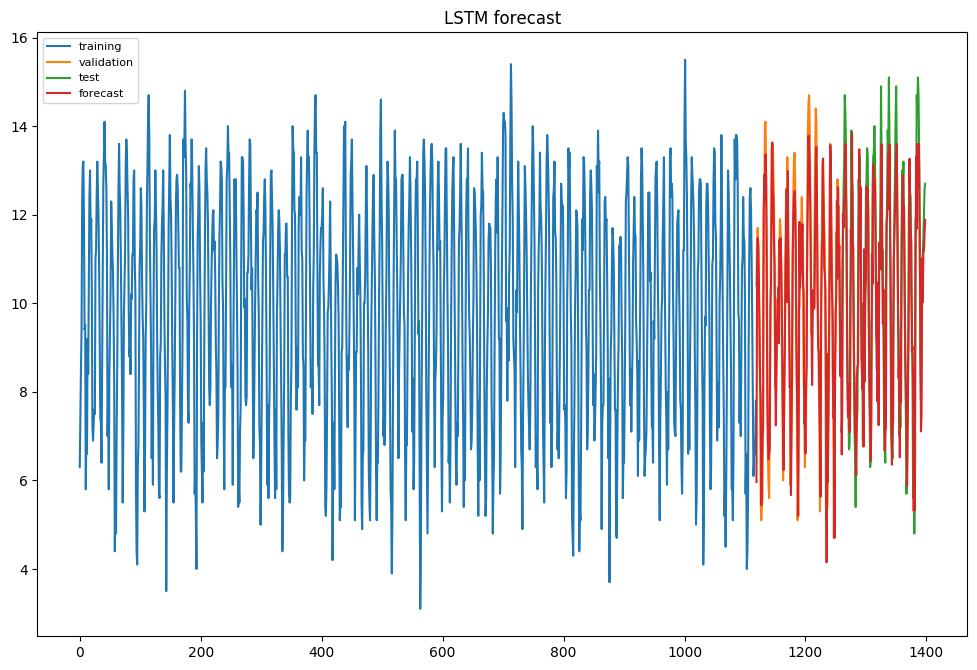

In [0]:
#forecast 2
forcast_ser2 = pd.Series(predictions2,index=merge_data.index)

plt.figure(figsize=(12,8),dpi=100)

plt.plot(train_data, label="training")
plt.plot(validation_data, label="validation")
plt.plot(test_data, label="test")

plt.plot(forcast_ser2, label="forecast")
plt.title("LSTM forecast")

plt.legend(loc="upper left", fontsize=8)
plt.show()

In [0]:
#save model result
print(len(forcast_ser2))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(forcast_ser2)

280
1119     5.964388
1120    10.826983
1121    11.471476
1122    11.290565
1123    10.556091
1124     9.583083
1125     8.198077
1126     7.834254
1127     5.443036
1128     6.107017
1129     6.927322
1130     7.174811
1131    12.149481
1132    12.903552
1133    12.314794
1134    13.365219
1135    12.766666
1136    11.121496
1137     8.004868
1138     6.829364
1139     6.482121
1140     6.614091
1141     6.729176
1142     9.912141
1143    10.406507
1144    12.033810
1145    13.631065
1146    12.612251
1147    12.260323
1148    11.339457
1149    10.882398
1150     8.485207
1151     7.242496
1152     8.377662
1153     9.440471
1154     9.937991
1155    10.350620
1156     9.095162
1157    11.436201
1158    11.024281
1159    11.474200
1160    10.814826
1161     9.791662
1162     8.275454
1163     7.007789
1164     6.232398
1165     8.078612
1166     9.116393
1167    10.801303
1168    11.737177
1169    12.564604
1170    10.027871
1171    12.987174
1172    10.343876
1173     9.943675
1174  

In [0]:
#validation error 
forecast_accuracy(predictions[:140],validation_data.values)

{'mae': 2.647044916862128,
 'mape': 0.29925686081093533,
 'me': -0.09020716837474249,
 'mpe': 0.07083136986601289,
 'rmse': 3.2615505157829836}

In [0]:
#validation error 2
forecast_accuracy(predictions2[:140],validation_data.values)

{'mae': 2.742882310501167,
 'mape': 0.3073909250473136,
 'me': -0.19066514985901922,
 'mpe': 0.060034458790851716,
 'rmse': 3.3855820221350537}

In [0]:
#test error
forecast_accuracy(predictions[140:],test_data.values)

{'mae': 2.7192714132362483,
 'mape': 0.2862409369064852,
 'me': -0.17625366449356056,
 'mpe': 0.05509407789191103,
 'rmse': 3.3296831283776847}

In [0]:
#test error 2
forecast_accuracy(predictions2[140:],test_data.values)

{'mae': 2.8089558634964784,
 'mape': 0.2926837180790519,
 'me': -0.33538697540760015,
 'mpe': 0.038779748031290286,
 'rmse': 3.44792002320002}

**9/** Surprisingly, the first model has better validation results than the second one. It appears adding an aditionnal layer did not do much gain; so we will keep the initial (1,1500,1) model as the definite model.

**11-12-13/** We don't notice a particular problem of overfitting yet; but rather the opposite, there may be an underfitting problem due to the restraint of nb_epoch=1500 that we have applied, which, is apparently not enough to perfectly train our model.

Indeed, we can graphically notice that the results we have optained are slightly off balance, although they have taken very good impressive shape of our expected result, compared to the statistical results we had in part one; it is very clear in the comparative graphes below.

**14-15/** plot comparison statistical vs Machine Learning :

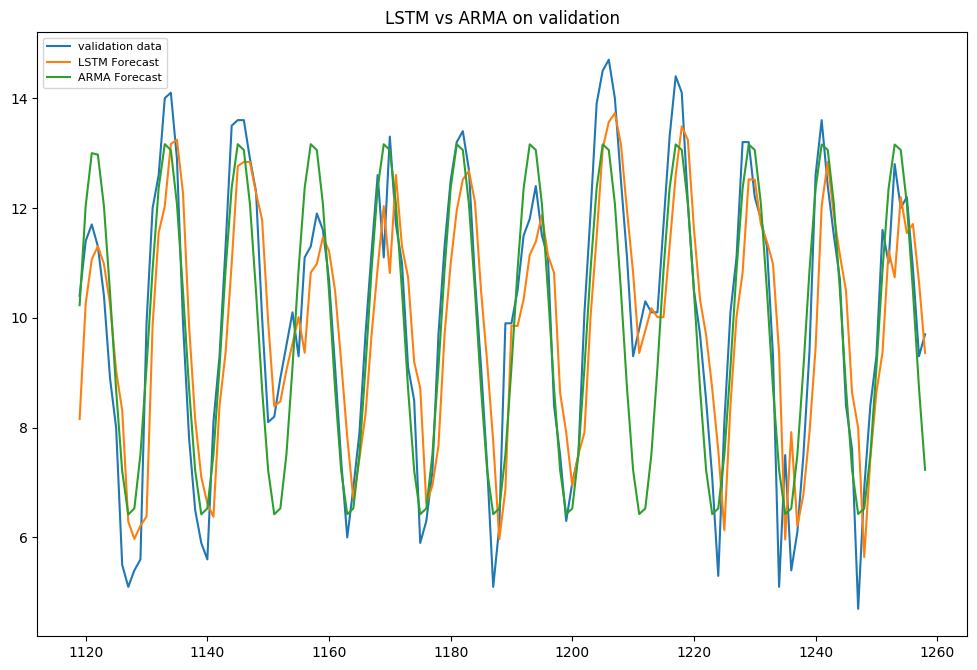

In [0]:
#validation comparison plot

plt.figure(figsize=(12,8),dpi=100)

plt.plot(validation_data, label="validation data")
plt.plot(forcast_ser[:140], label="LSTM Forecast")
plt.plot(fc_series[:140], label="ARMA Forecast")

plt.title("LSTM vs ARMA on validation")

plt.legend(loc="upper left",fontsize=8)
plt.show()



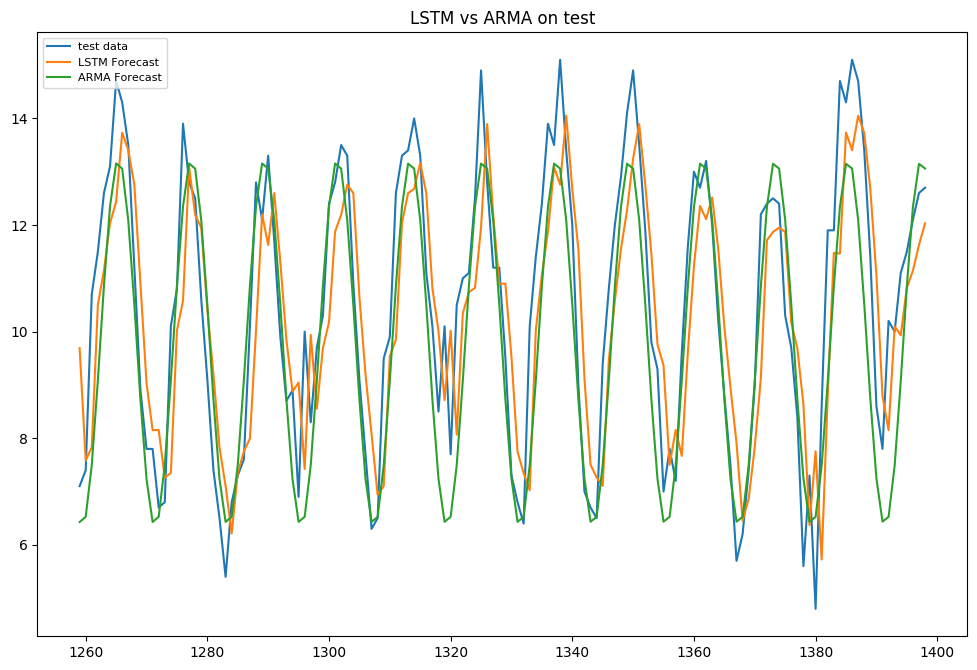

In [0]:
#test comparison plot

plt.figure(figsize=(12,8),dpi=100)

plt.plot(test_data, label="test data")
plt.plot(forcast_ser[140:], label="LSTM Forecast")
plt.plot(fc_series[140:], label="ARMA Forecast")

plt.title("LSTM vs ARMA on test")

plt.legend(loc="upper left",fontsize=8)
plt.show()

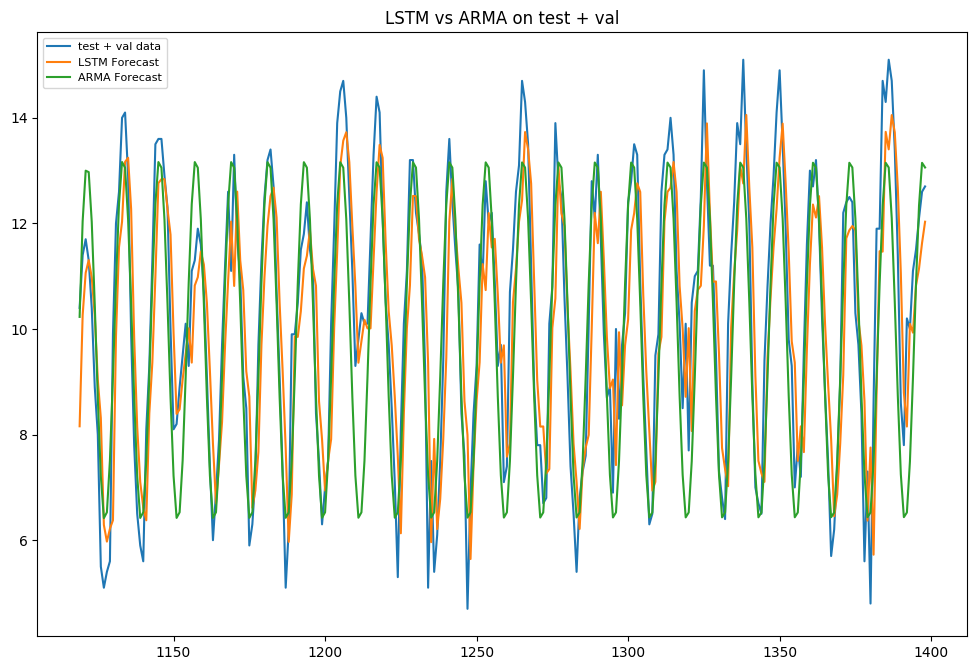

In [0]:
#test+val comparison plot

plt.figure(figsize=(12,8),dpi=100)

plt.plot(merge_data, label="test + val data")
plt.plot(forcast_ser, label="LSTM Forecast")
plt.plot(fc_series, label="ARMA Forecast")

plt.title("LSTM vs ARMA on test + val")

plt.legend(loc="upper left",fontsize=8)
plt.show()



**16+17/** Although the final LSTM model is incomplete, it is still slightly better than the results of the first part.

For instance, the MAPE of LSTM was 0.28, indicating that 72% of the forecasts were accurate; whereas the MAPE of ARMA was 0.31, indicating that 69% of the forecasts are accurate.

That said, i highly suggest redoing LSTM with a really powerful model given the computing resources such as (1,3000,1); which may raise these results quite ahead.

Until then, given the amount of resources and time it takes to use these RNNs or machine learning models, compared to the much statistical models; all for a result with relatively equal performance (for now)